In [1]:
# Cell 1: Import necessary libraries

import json
import os
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from imblearn.over_sampling import SMOTE
from matplotlib.colors import ListedColormap

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, RocCurveDisplay

from copy import deepcopy
from collections import Counter
from typing import Optional, Tuple
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings('ignore')

In [2]:
# ---- Config ----
EXPECTED_FILES = {
    "nsl_kdd": ["nsl-kdd/KDDTrain+.txt"],
    "ton_iot": ["NF-ToN-IoT-v2.csv"],
}

# ---- Helpers to find the data directory ----
def _contains_expected_files(base: Path) -> bool:
    return all((base / rel).exists()
               for rels in EXPECTED_FILES.values()
               for rel in rels)

def _load_config_json(start: Path) -> Optional[Path]:
    """
    Search upward from `start` for a config.json with {"data_dir": "..."}.
    """
    for p in [start, *start.parents]:
        cfg = p / "config.json"
        if cfg.exists():
            try:
                cfg_obj = json.loads(cfg.read_text(encoding="utf-8"))
                if isinstance(cfg_obj, dict) and "data_dir" in cfg_obj:
                    candidate = Path(str(cfg_obj["data_dir"])).expanduser()
                    if candidate.exists():
                        return candidate
            except Exception:
                # Ignore malformed config and continue searching upward
                pass
    return None

def _discover_data_dir(start: Path) -> Optional[Path]:
    """
    Try common defaults and an upward search for a 'data' directory that has expected files.
    """
    candidates = [
        start / "data",
        start.parent / "data",
        start.parent.parent / "data",
    ]
    for p in [start, *start.parents]:
        candidates.append(p / "data")

    seen = set()
    for c in candidates:
        c = c.resolve()
        if c in seen:
            continue
        seen.add(c)
        if c.exists() and c.is_dir() and _contains_expected_files(c):
            return c
    return None

def resolve_data_dir(explicit: Optional[str] = None) -> Path:
    """
    Resolve the data directory with the following precedence:
      1) explicit arg
      2) env var ADV_DATA_DIR or DATA_DIR
      3) config.json (search upward)
      4) discovery (./data, ../data, ...)
    """
    # 1) explicit
    if explicit:
        p = Path(explicit).expanduser().resolve()
        if p.exists():
            return p
        raise FileNotFoundError(f"DATA_DIR '{p}' does not exist.")

    # 2) env var(s)
    for key in ("ADV_DATA_DIR", "DATA_DIR"):
        env_dir = os.environ.get(key)
        if env_dir:
            p = Path(env_dir).expanduser().resolve()
            if p.exists():
                return p
            raise FileNotFoundError(f"Environment {key}='{p}' does not exist.")

    # 3) config.json
    start = Path.cwd().resolve()
    cfg_dir = _load_config_json(start)
    if cfg_dir:
        return cfg_dir.resolve()

    # 4) discovery
    found = _discover_data_dir(start)
    if found:
        return found

    # If we got here, nothing worked
    raise FileNotFoundError(
        "Could not locate a valid data directory.\n"
        "Tried: explicit path, $ADV_DATA_DIR/$DATA_DIR, config.json, ./data, ../data, and discovery.\n"
        "Fix by either: (a) passing resolve_data_dir('E:/Advanced/data'), "
        "(b) setting ADV_DATA_DIR or DATA_DIR, or (c) creating config.json with {'data_dir': '...'}."
    )

def get_dataset_paths(data_dir: Path) -> Tuple[Path, Path]:
    nsl_kdd_train = data_dir / "nsl-kdd" / "KDDTrain+.txt"
    ton_iot = data_dir / "NF-ToN-IoT-v2.csv"

    missing = [p for p in (nsl_kdd_train, ton_iot) if not p.exists()]
    if missing:
        msg = "Missing required dataset files:\n" + "\n".join(f" - {m}" for m in missing)
        raise FileNotFoundError(msg)
    return nsl_kdd_train, ton_iot

def write_example_config_json(target_dir: Path) -> Path:
    """
    Convenience: create config.json with {\"data_dir\": \"...\"} at the project root.
    """
    cfg = target_dir / "config.json"
    if not cfg.exists():
        cfg.write_text(json.dumps({"data_dir": str(target_dir / "data")}, indent=2), encoding="utf-8")
    return cfg

# ---- Robust dataset loaders ----
def load_nsl_kdd(nsl_kdd_path: Path):
    """
    NSL-KDD KDDTrain+.txt is commonly comma-delimited without header.
    We try comma first, then tab as a fallback.
    """

    column_names = [
        'duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
        'wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised',
        'root_shell','su_attempted','num_root','num_file_creations','num_shells',
        'num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
        'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
        'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
        'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
        'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
        'dst_host_srv_rerror_rate','label','difficulty'
    ]

    try:
        return pd.read_csv(nsl_kdd_path, sep=",", header=None, names=column_names, encoding="utf-8", low_memory=False)
    except Exception:
        # Fallback to tab-delimited if comma fails
        return pd.read_csv(nsl_kdd_path, sep="\t", header=None, names=column_names, encoding="utf-8", engine="python", low_memory=False)

def load_ton_iot(ton_iot_path: Path):
    """
    ToN-IoT CSV loader (utf-8). Adjust dtypes later if needed.
    """
    import pandas as pd
    return pd.read_csv(ton_iot_path, encoding="utf-8", low_memory=False)

try:
    data_dir = resolve_data_dir()

    nsl_kdd_path, ton_iot_path = get_dataset_paths(data_dir)
    print("✅ Using data dir:", data_dir)
    print(" - NSL-KDD:", nsl_kdd_path)
    print(" - ToN-IoT:", ton_iot_path)

    # Load
    nsl_kdd_df = load_nsl_kdd(nsl_kdd_path)
    ton_iot_df = load_ton_iot(ton_iot_path)
    print("✅ Loaded datasets. Shapes:", nsl_kdd_df.shape, ton_iot_df.shape)

except FileNotFoundError as e:
    print("❌", e)


✅ Using data dir: E:\Advanced\data
 - NSL-KDD: E:\Advanced\data\nsl-kdd\KDDTrain+.txt
 - ToN-IoT: E:\Advanced\data\NF-ToN-IoT-v2.csv
✅ Loaded datasets. Shapes: (125973, 43) (16940496, 45)


In [3]:
# Cell 3: Preprocess and apply SMOTE to both datasets
# Process NSL-KDD
nsl_kdd_df.drop(columns=['difficulty'], inplace=True)

# Encode categorical columns
categorical_cols = ['protocol_type', 'service', 'flag']
nsl_kdd_df[categorical_cols] = nsl_kdd_df[categorical_cols].apply(LabelEncoder().fit_transform)

# Binary classification: normal vs attack
nsl_kdd_df['label'] = nsl_kdd_df['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')
nsl_kdd_df['label'] = nsl_kdd_df['label'].map({'normal': 0, 'attack': 1})

# Select a subset of less correlated / less leakage-prone features
selected_features = [
    'duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate'
]

X_nsl = nsl_kdd_df[selected_features]
y_nsl = nsl_kdd_df['label']

print("NSL-KDD class distribution before SMOTE:")
print(pd.Series(y_nsl).value_counts())

# Apply SMOTE to NSL-KDD
smote = SMOTE(random_state=42)
X_nsl_res, y_nsl_res = smote.fit_resample(X_nsl, y_nsl)

print("NSL-KDD class distribution after SMOTE:")
print(pd.Series(y_nsl_res).value_counts())

# Sample TON_IoT dataset for faster processing
ton_sample = ton_iot_df.sample(n=150000, random_state=42)
ton_sample = ton_sample.select_dtypes(include=[np.number])

# Split features and label
y_ton = ton_sample.iloc[:, -1].map({1: 0, 0: 1})
X_ton = ton_sample.iloc[:, :-1]

print("TON_IoT sample class distribution before SMOTE:")
print(pd.Series(y_ton).value_counts())

# Apply SMOTE to TON_IoT sample
X_ton_res, y_ton_res = smote.fit_resample(X_ton, y_ton)
print("TON_IoT sample class distribution after SMOTE:")
print(pd.Series(y_ton_res).value_counts())

NSL-KDD class distribution before SMOTE:
label
0    67343
1    58630
Name: count, dtype: int64
NSL-KDD class distribution after SMOTE:
label
0    67343
1    67343
Name: count, dtype: int64
TON_IoT sample class distribution before SMOTE:
Label
0    95969
1    54031
Name: count, dtype: int64
TON_IoT sample class distribution after SMOTE:
Label
0    95969
1    95969
Name: count, dtype: int64


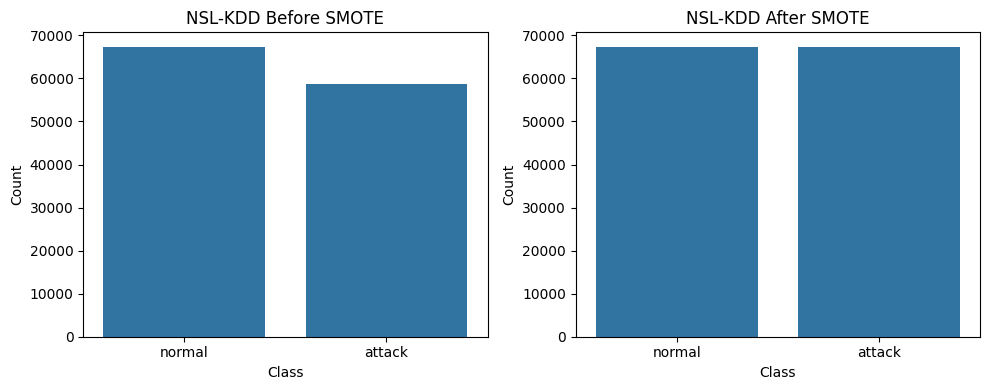

In [4]:
# Cell 3.1: Compare NSL-KDD before and after SMOTE
original_counts = pd.Series(y_nsl).value_counts()
resampled_counts = pd.Series(y_nsl_res).value_counts()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x=original_counts.index.map({0: 'normal', 1: 'attack'}), y=original_counts.values, ax=axes[0])
axes[0].set_title("NSL-KDD Before SMOTE")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.barplot(x=resampled_counts.index.map({0: 'normal', 1: 'attack'}), y=resampled_counts.values, ax=axes[1])
axes[1].set_title("NSL-KDD After SMOTE")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [5]:
# Cell 3.2: NSL-KDD explanation after SMOTE

print("🔍 Descriptive Statistics:")
display(X_nsl_res.describe())

print("\n🧪 First 5 rows of the label:")
display(X_nsl_res.head())

print("\n⚠️ Attack Class Distribution in Original Dataset (before SMOTE) (1 = DDoS-like, 0 = Normal):")
attack_counts = X_nsl.value_counts()
print(attack_counts)

🔍 Descriptive Statistics:


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,count,srv_count,serror_rate,srv_serror_rate,rerror_rate
count,134686.000000,1.346860e+05,1.346860e+05,134686.000000,134686.000000,134686.000000,134686.000000,134686.000000,134686.000000,134686.000000
mean,298.858374,4.290254e+04,2.124695e+04,0.024353,0.000104,88.667501,27.715761,0.305357,0.303281,0.125138
std,2691.999689,5.677389e+06,4.009565e+06,0.262719,0.013894,116.427664,73.405778,0.455912,0.456634,0.326216
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,3.300000e+01,0.000000e+00,0.000000,0.000000,17.000000,8.000000,0.000000,0.000000,0.000000
75%,0.000000,2.600000e+02,4.150000e+02,0.000000,0.000000,149.000000,18.000000,1.000000,1.000000,0.000000
max,42908.000000,1.379964e+09,1.309937e+09,3.000000,3.000000,511.000000,511.000000,1.000000,1.000000,1.000000



🧪 First 5 rows of the label:


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,count,srv_count,serror_rate,srv_serror_rate,rerror_rate
0,0,491,0,0,0,2,2,0.0,0.0,0.0
1,0,146,0,0,0,13,1,0.0,0.0,0.0
2,0,0,0,0,0,123,6,1.0,1.0,0.0
3,0,232,8153,0,0,5,5,0.2,0.2,0.0
4,0,199,420,0,0,30,32,0.0,0.0,0.0



⚠️ Attack Class Distribution in Original Dataset (before SMOTE) (1 = DDoS-like, 0 = Normal):
duration  src_bytes  dst_bytes  wrong_fragment  urgent  count  srv_count  serror_rate  srv_serror_rate  rerror_rate
0         0          0          0               0       1      1          0.0          0.0              1.0            3121
          1032       0          0               0       511    511        0.0          0.0              0.0            1010
          18         0          0               0       1      1          0.0          0.0              0.0             520
          0          0          0               0       1      2          0.0          0.0              1.0             491
                                                               1          1.0          1.0              0.0             391
                                                                                                                       ... 
42198     1          0          0             

In [6]:
# Cell 3.3: Train Random Forest and XGBoost on NSL-KDD
X_train_nsl, X_test_nsl, y_train_nsl, y_test_nsl = train_test_split(X_nsl_res, y_nsl_res, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_nsl, y_train_nsl)
y_pred_rf = rf_model.predict(X_test_nsl)
print("Random Forest Classification Report:")
print(classification_report(y_test_nsl, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test_nsl, y_pred_rf))

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_nsl, y_train_nsl)
y_pred_xgb = xgb_model.predict(X_test_nsl)
print("XGBoost Classification Report:")
print(classification_report(y_test_nsl, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test_nsl, y_pred_xgb))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13389
           1       1.00      0.98      0.99     13549

    accuracy                           0.99     26938
   macro avg       0.99      0.99      0.99     26938
weighted avg       0.99      0.99      0.99     26938

Confusion Matrix:
[[13350    39]
 [  313 13236]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13389
           1       1.00      0.98      0.99     13549

    accuracy                           0.99     26938
   macro avg       0.99      0.99      0.99     26938
weighted avg       0.99      0.99      0.99     26938

Confusion Matrix:
[[13336    53]
 [  314 13235]]


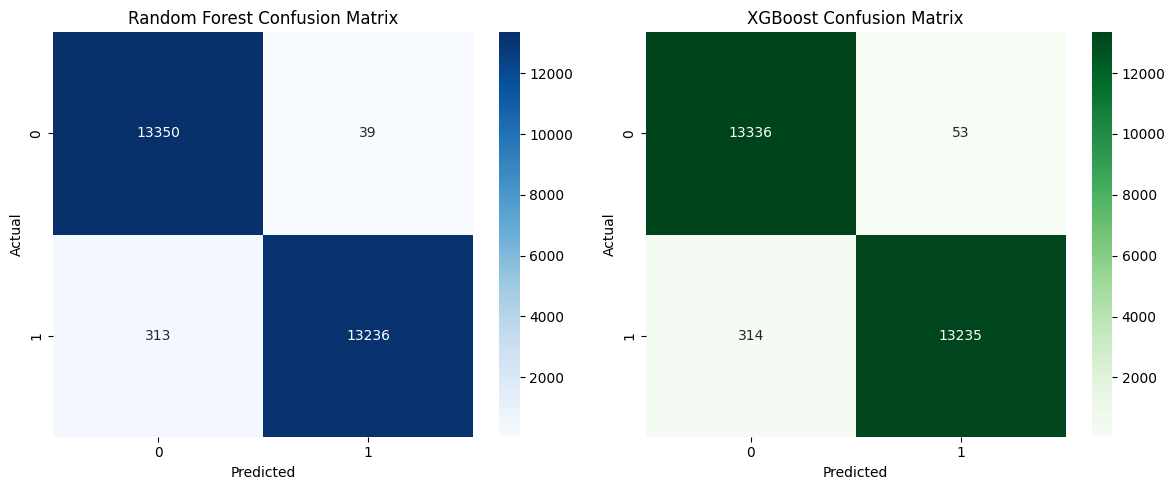

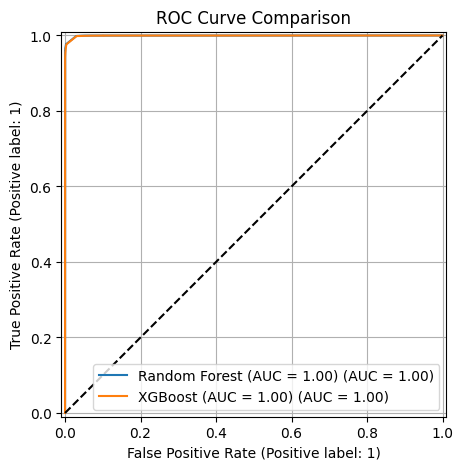

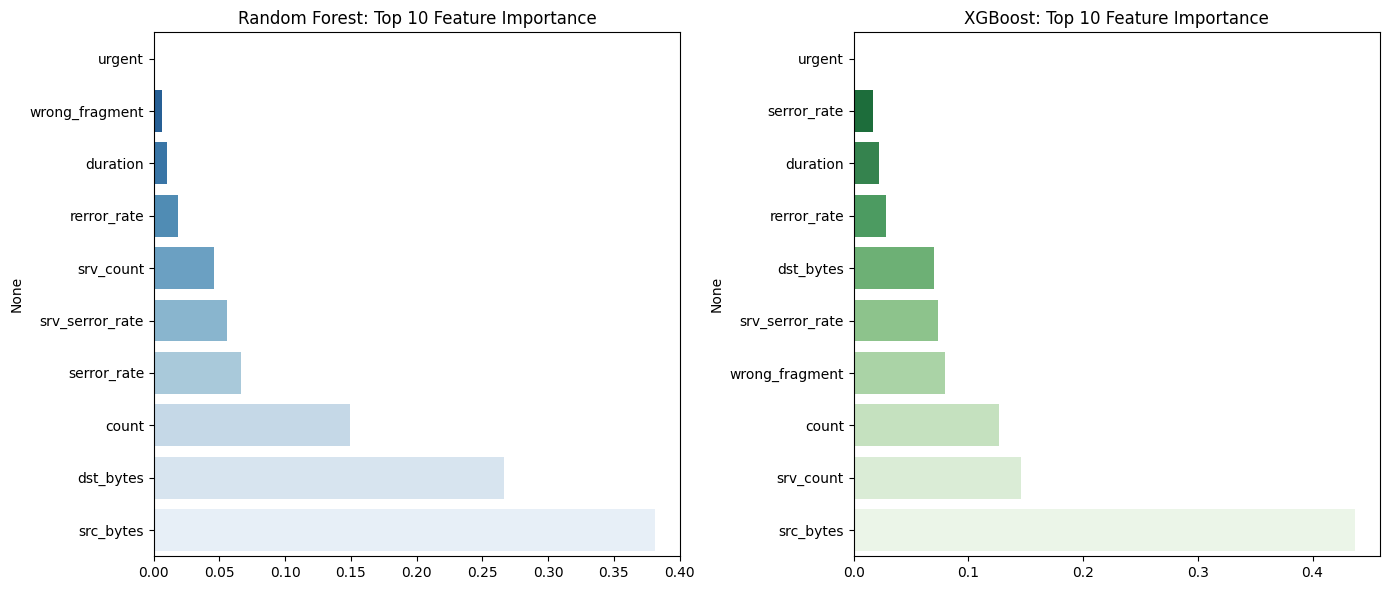

In [7]:
# Cell 3.4: Enhanced Evaluation with Visualization

# 1️⃣ Confusion Matrix Heatmaps (Side by Side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_nsl, y_pred_rf), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test_nsl, y_pred_xgb), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 2️⃣ ROC Curve Comparison
y_proba_rf = rf_model.predict_proba(X_test_nsl)[:, 1]
y_proba_xgb = xgb_model.predict_proba(X_test_nsl)[:, 1]

fig, ax = plt.subplots(figsize=(7, 5))

RocCurveDisplay.from_predictions(
    y_test_nsl, y_proba_rf,
    name=f'Random Forest (AUC = {roc_auc_score(y_test_nsl, y_proba_rf):.2f})',
    ax=ax
)

RocCurveDisplay.from_predictions(
    y_test_nsl, y_proba_xgb,
    name=f'XGBoost (AUC = {roc_auc_score(y_test_nsl, y_proba_xgb):.2f})',
    ax=ax
)

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.grid()
plt.show()

# 3️⃣ Feature Importance (Top 10 Features Sorted)
importances_rf = rf_model.feature_importances_
importances_xgb = xgb_model.feature_importances_
features = X_train_nsl.columns

# Sort indices for Top 10 features
top_idx_rf = np.argsort(importances_rf)[-10:]
top_idx_xgb = np.argsort(importances_xgb)[-10:]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=importances_rf[top_idx_rf], y=features[top_idx_rf], ax=axes[0], palette='Blues_r')
axes[0].set_title('Random Forest: Top 10 Feature Importance')

sns.barplot(x=importances_xgb[top_idx_xgb], y=features[top_idx_xgb], ax=axes[1], palette='Greens_r')
axes[1].set_title('XGBoost: Top 10 Feature Importance')

plt.tight_layout()
plt.show()

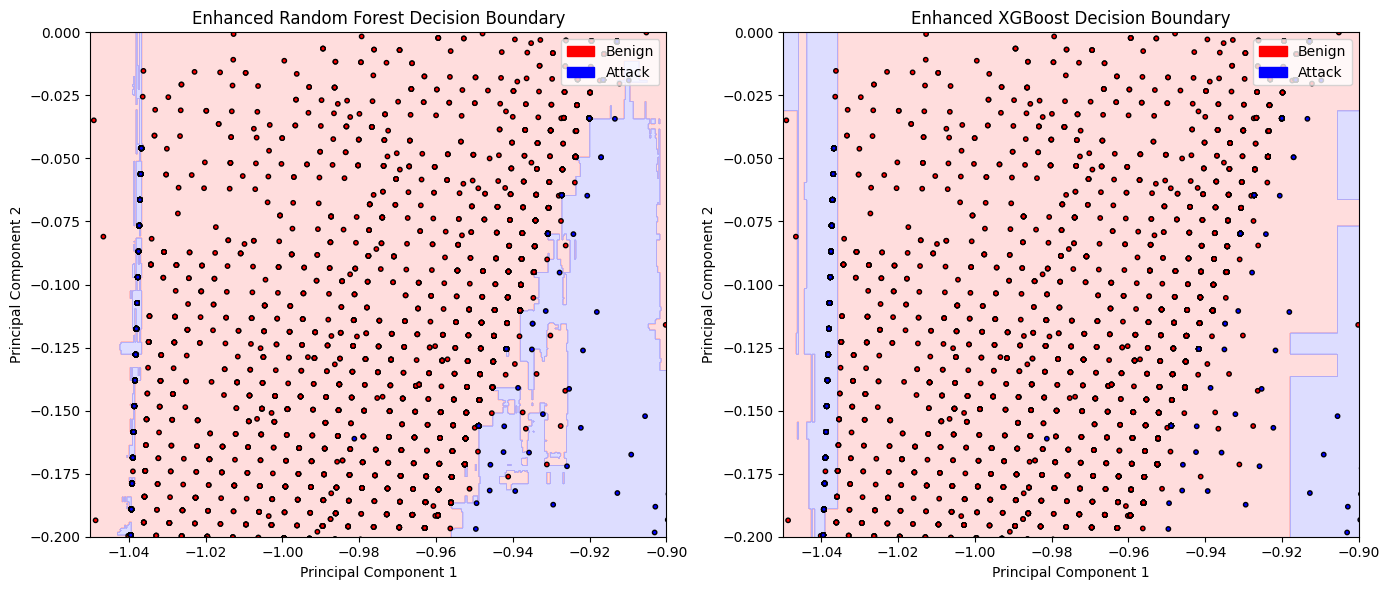

In [8]:
# Cell 3.5: Enhanced Decision Boundary Visualization

# Step 1: Standardize features before PCA
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_nsl_res)  # X_nsl_res is the SMOTE-processed data

# Step 2: Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_res_scaled)

# Step 3: Train models on PCA-reduced data
rf = RandomForestClassifier()
rf.fit(X_pca, y_nsl_res)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_pca, y_nsl_res)

# Step 4: Function to plot decision boundaries
def plot_decision_boundary(model, X, y, ax, title):
    x_min, x_max = -1.05, -0.9
    y_min, y_max = -0.2, 0
   # x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
   # y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])  # red=class 0, blue=class 1 background
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])   # red=class 0, blue=class 1 points

    ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    # Add legend
    red_patch = mpatches.Patch(color='#FF0000', label='Benign')
    blue_patch = mpatches.Patch(color='#0000FF', label='Attack')
    ax.legend(handles=[red_patch, blue_patch], loc='upper right')

# Step 5: Plot both models side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_boundary(rf, X_pca, y_nsl_res, axs[0], "Enhanced Random Forest Decision Boundary")
plot_decision_boundary(xgb, X_pca, y_nsl_res, axs[1], "Enhanced XGBoost Decision Boundary")
plt.tight_layout()
plt.show()

Label distribution before SMOTE: {0: 95969, 1: 54031}


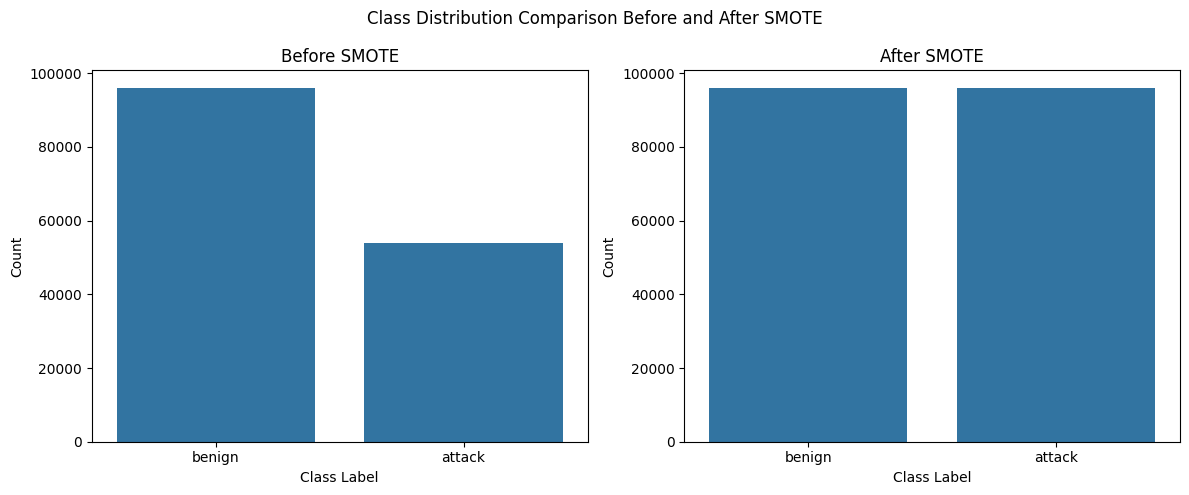

In [9]:
# 3.6 Compare TON Dataset Before and After SMOTE

# Inspect label distribution to confirm correct mapping
print('Label distribution before SMOTE:', pd.Series(y_ton).value_counts().to_dict())

labels_before = pd.Series(y_ton).value_counts()
labels_after = pd.Series(y_ton_res).value_counts()

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Assuming 0 = benign, 1 = attack
sns.barplot(x=labels_before.index.map({0: 'benign', 1: 'attack'}), y=labels_before.values, ax=axes[0])
axes[0].set_title('Before SMOTE')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Class Label')

sns.barplot(x=labels_after.index.map({0: 'benign', 1: 'attack'}), y=labels_after.values, ax=axes[1])
axes[1].set_title('After SMOTE')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Class Label')

plt.suptitle('Class Distribution Comparison Before and After SMOTE')
plt.tight_layout()
plt.show()

In [10]:
# Cell 3.7: TON explanation after SMOTE

print("🔍 Descriptive Statistics:")
display(X_ton_res.describe())

print("\n🧪 First 5 rows of the label:")
display(X_ton_res.head())

print("\n⚠️ Attack Class Distribution in Original Dataset (before SMOTE) (1 = DDoS-like, 0 = Normal):")
attack_counts = X_ton.value_counts()
print(attack_counts)

🔍 Descriptive Statistics:


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
count,191938.000000,191938.000000,191938.000000,191938.000000,1.919380e+05,191938.000000,1.919380e+05,191938.000000,191938.000000,191938.000000,...,191938.000000,191938.000000,191938.000000,191938.000000,191938.000000,191938.000000,191938.000000,191938.000000,191938.000000,191938.000000
mean,43474.489095,9754.030400,7.467234,12.815978,6.329398e+02,5.043306,6.944966e+02,4.502730,12.087398,8.368968,...,0.155415,0.418010,9208.440950,8664.254535,396.286843,1.546765,4175.810876,1.422616,5759.117147,1.170717
std,15607.313222,16834.600697,3.770276,31.314657,5.263481e+04,124.174311,4.667605e+04,840.689097,11.155762,10.439171,...,9.627153,35.337601,13216.455301,16788.750793,3919.237799,15.302294,12849.876945,9.373294,56084.803032,22.976093
min,0.000000,0.000000,1.000000,0.000000,4.000000e+00,1.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37644.000000,80.000000,6.000000,0.000000,4.400000e+01,1.000000,0.000000e+00,0.000000,2.000000,2.000000,...,0.000000,0.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,46024.000000,1092.000000,6.000000,0.000000,4.800000e+01,1.000000,4.000000e+01,1.000000,2.000000,2.000000,...,0.000000,0.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,54536.000000,8834.000000,6.000000,7.000000,1.640000e+02,3.000000,1.340000e+02,2.000000,22.000000,18.000000,...,0.000000,0.000000,28960.000000,5792.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,65534.000000,65535.000000,58.000000,248.000000,2.117210e+07,20000.000000,1.875429e+07,367218.000000,223.000000,223.000000,...,3356.000000,14511.000000,65535.000000,65535.000000,65280.000000,255.000000,65534.000000,255.000000,604800.000000,550.000000



🧪 First 5 rows of the label:


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
0,58592,80,6,7.000,661,10,2234,8,27,27,...,0,1,29200,65535,0,0,0,0,0,0
1,41436,443,6,91.000,112,2,112,2,19,18,...,0,0,29200,28960,0,0,0,0,0,0
2,32374,25720,6,0.000,48,1,0,0,2,2,...,0,0,4096,0,0,0,0,0,0,0
3,53904,80,6,7.178,4106,8,2132,7,27,27,...,1,3,29200,26847,0,0,0,0,0,0
4,42453,5544,6,0.000,44,1,0,0,2,2,...,0,0,1024,0,0,0,0,0,0,0



⚠️ Attack Class Distribution in Original Dataset (before SMOTE) (1 = DDoS-like, 0 = Normal):
L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  OUT_PKTS  TCP_FLAGS  CLIENT_TCP_FLAGS  SERVER_TCP_FLAGS  FLOW_DURATION_MILLISECONDS  DURATION_IN  DURATION_OUT  MIN_TTL  MAX_TTL  LONGEST_FLOW_PKT  SHORTEST_FLOW_PKT  MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  SRC_TO_DST_SECOND_BYTES  DST_TO_SRC_SECOND_BYTES  RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  SRC_TO_DST_AVG_THROUGHPUT  DST_TO_SRC_AVG_THROUGHPUT  NUM_PKTS_UP_TO_128_BYTES  NUM_PKTS_128_TO_256_BYTES  NUM_PKTS_256_TO_512_BYTES  NUM_PKTS_512_TO_1024_BYTES  NUM_PKTS_1024_TO_1514_BYTES  TCP_WIN_MAX_IN  TCP_WIN_MAX_OUT  ICMP_TYPE  ICMP_IPV4_TYPE  DNS_QUERY_ID  DNS_QUERY_TYPE  DNS_TTL_ANSWER  FTP_COMMAND_RET_CODE
44727        80           6         7.0       40        1        0          0         16         16                0                 0                           0     

In [11]:
# Cell 3.8: Train Random Forest and XGBoost on TON
X_train_ton, X_test_ton, y_train_ton, y_test_ton = train_test_split(X_ton_res, y_ton_res, test_size=0.2, random_state=42)

rf_model_ton = RandomForestClassifier(random_state=42)
rf_model_ton.fit(X_train_ton, y_train_ton)
y_pred_rf_ton = rf_model_ton.predict(X_test_ton)
print("Random Forest Classification Report:")
print(classification_report(y_test_ton, y_pred_rf_ton))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ton, y_pred_rf_ton))

xgb_model_ton = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model_ton.fit(X_train_ton, y_train_ton)
y_pred_xgb_ton = xgb_model_ton.predict(X_test_ton)
print("XGBoost Classification Report:")
print(classification_report(y_test_ton, y_pred_xgb_ton))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ton, y_pred_xgb_ton))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19103
           1       1.00      0.99      0.99     19285

    accuracy                           0.99     38388
   macro avg       0.99      0.99      0.99     38388
weighted avg       0.99      0.99      0.99     38388

Confusion Matrix:
[[19018    85]
 [  158 19127]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19103
           1       0.99      0.99      0.99     19285

    accuracy                           0.99     38388
   macro avg       0.99      0.99      0.99     38388
weighted avg       0.99      0.99      0.99     38388

Confusion Matrix:
[[18994   109]
 [  195 19090]]


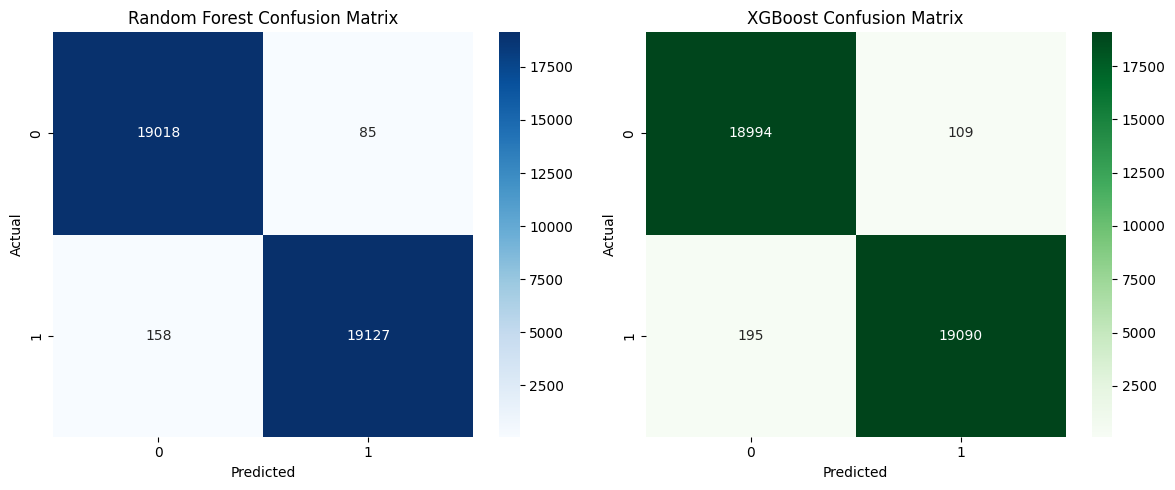

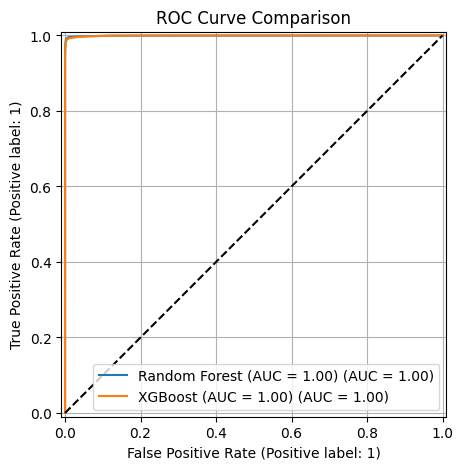

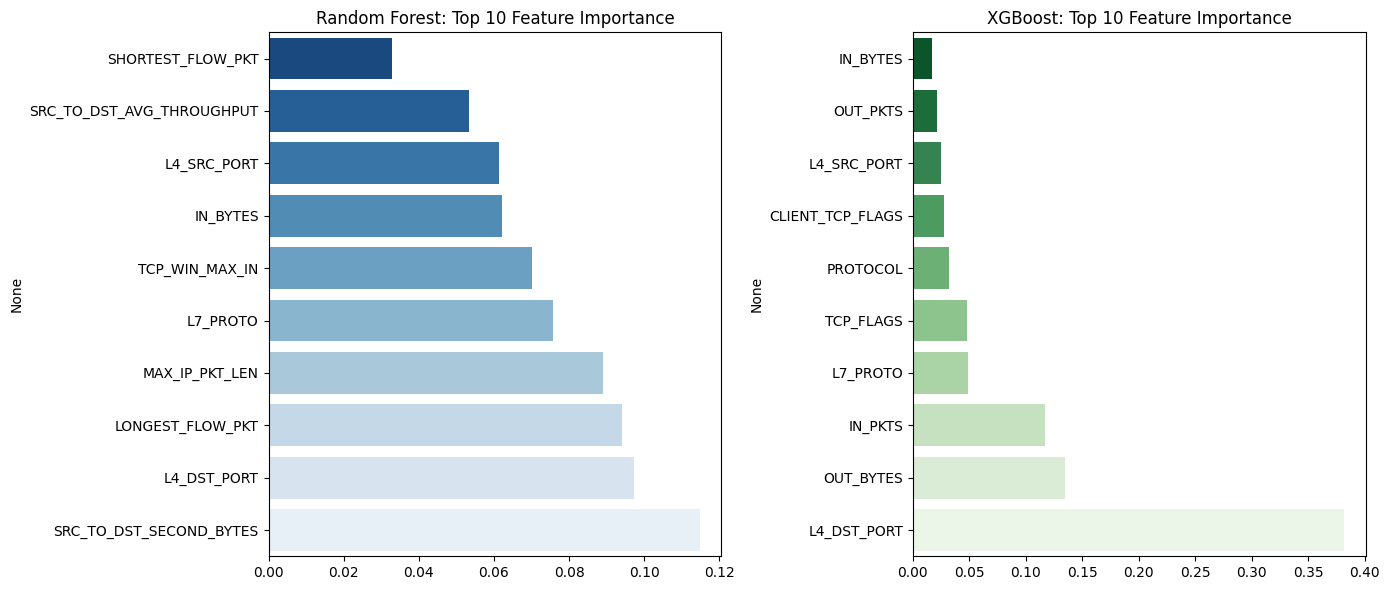

In [12]:
# Cell 3.9: Enhanced Evaluation with Visualization

# 1️⃣ Confusion Matrix Heatmaps (Side by Side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_ton, y_pred_rf_ton), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test_ton, y_pred_xgb_ton), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 2️⃣ ROC Curve Comparison
y_proba_rf_ton = rf_model_ton.predict_proba(X_test_ton)[:, 1]
y_proba_xgb_ton = xgb_model_ton.predict_proba(X_test_ton)[:, 1]

fig, ax = plt.subplots(figsize=(7, 5))

RocCurveDisplay.from_predictions(
    y_test_ton, y_proba_rf_ton,
    name=f'Random Forest (AUC = {roc_auc_score(y_test_ton, y_proba_rf_ton):.2f})',
    ax=ax
)

RocCurveDisplay.from_predictions(
    y_test_ton, y_proba_xgb_ton,
    name=f'XGBoost (AUC = {roc_auc_score(y_test_ton, y_proba_xgb_ton):.2f})',
    ax=ax
)

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.grid()
plt.show()

# 3️⃣ Feature Importance (Top 10 Features Sorted)
importances_rf_ton = rf_model_ton.feature_importances_
importances_xgb_ton = xgb_model_ton.feature_importances_
features_ton = X_train_ton.columns

# Sort indices for Top 10 features
top_idx_rf_ton = np.argsort(importances_rf_ton)[-10:]
top_idx_xgb_ton = np.argsort(importances_xgb_ton)[-10:]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=importances_rf_ton[top_idx_rf_ton], y=features_ton[top_idx_rf_ton], ax=axes[0], palette='Blues_r')
axes[0].set_title('Random Forest: Top 10 Feature Importance')

sns.barplot(x=importances_xgb_ton[top_idx_xgb_ton], y=features_ton[top_idx_xgb], ax=axes[1], palette='Greens_r')
axes[1].set_title('XGBoost: Top 10 Feature Importance')

plt.tight_layout()
plt.show()

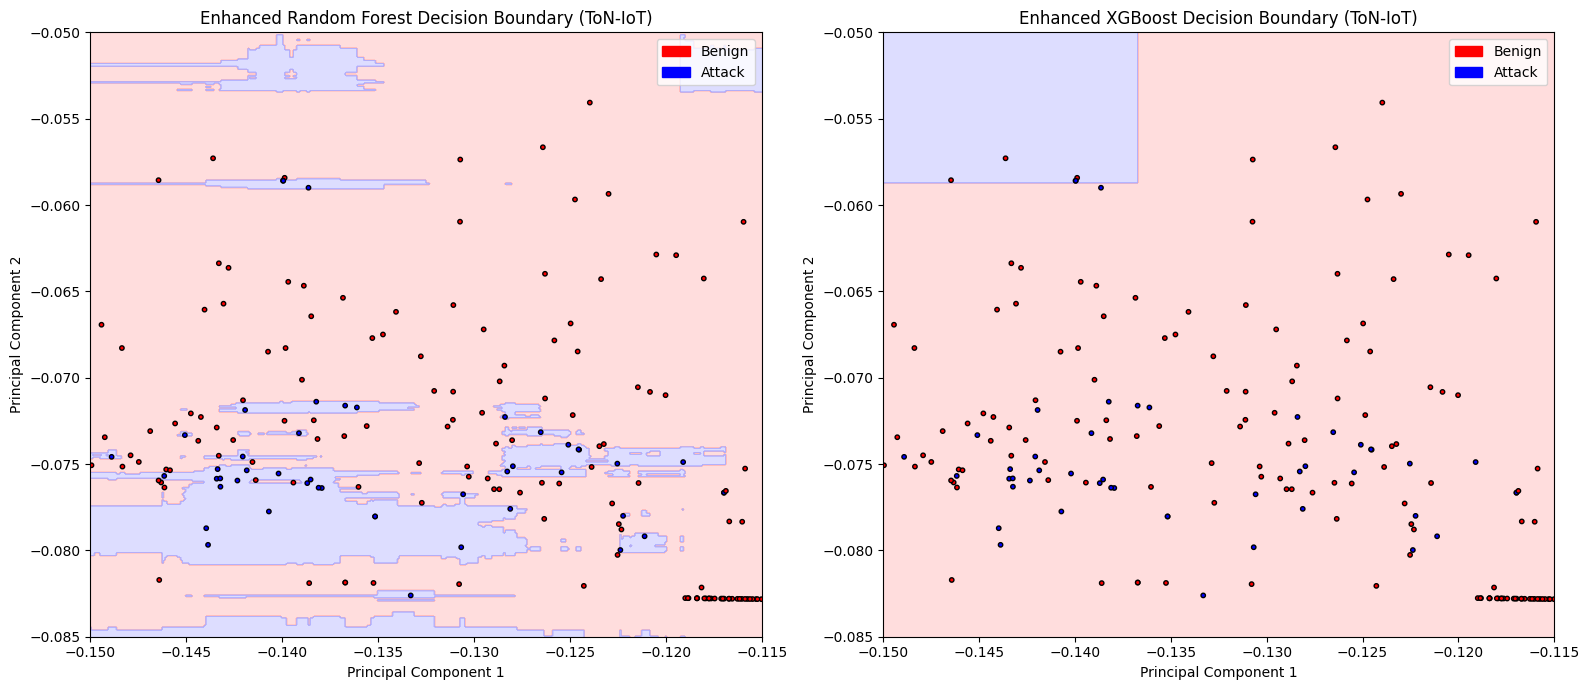

In [13]:
# Cell 3.10: Enhanced Decision Boundary Visualization for ToN-IoT

# Step 1: Standardize features before PCA
scaler = StandardScaler()
X_ton_res_scaled = scaler.fit_transform(X_ton_res)  # X_ton_res is the SMOTE-processed data for ToN-IoT

# Step 2: Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_ton_pca = pca.fit_transform(X_ton_res_scaled)

# Step 3: Train models on PCA-reduced full data
rf_ton = RandomForestClassifier()
rf_ton.fit(X_ton_pca, y_ton_res)

xgb_ton = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_ton.fit(X_ton_pca, y_ton_res)

# Step 4: Function to plot decision boundaries

def plot_decision_boundary(model, X, y, ax, title):
    # Limit axis range to focus on main cluster
    x_min, x_max = -0.15, -0.115
    y_min, y_max = -0.085, -0.05

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])  # red=class 0, blue=class 1 background
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])   # red=class 0, blue=class 1 points

    ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    # Add legend
    red_patch = mpatches.Patch(color='#FF0000', label='Benign')
    blue_patch = mpatches.Patch(color='#0000FF', label='Attack')
    ax.legend(handles=[red_patch, blue_patch], loc='upper right')

# Step 5: Plot both models side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
plot_decision_boundary(rf_ton, X_ton_pca, y_ton_res, axs[0], "Enhanced Random Forest Decision Boundary (ToN-IoT)")
plot_decision_boundary(xgb_ton, X_ton_pca, y_ton_res, axs[1], "Enhanced XGBoost Decision Boundary (ToN-IoT)")
plt.tight_layout()
plt.show()


In [14]:
# Cell 4: Combine NSL-KDD and ToN-IoT Datasets (Both SMOTE-processed)

# Combine datasets
# Ensure ToN-IoT has only 10 features to match NSL-KDD
X_ton_res_matched = X_ton_res.iloc[:, :10] 

# Combine feature and label arrays
X_combined = np.vstack((X_nsl_res, X_ton_res_matched))
y_combined = np.hstack((y_nsl_res, y_ton_res))

# Store original (unencoded) labels for Cell 4.3
y_combined_original = deepcopy(y_combined)

# Standardize and reduce to 2D with PCA
scaler_combined = StandardScaler()
X_combined_scaled = scaler_combined.fit_transform(X_combined)

pca_combined = PCA(n_components=2)
X_combined_pca = pca_combined.fit_transform(X_combined_scaled)

# Train models on combined dataset
rf_combined = RandomForestClassifier()
rf_combined.fit(X_combined_pca, y_combined)

xgb_combined = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_combined.fit(X_combined_pca, y_combined)

# Predict
y_rf_pred = rf_combined.predict(X_combined_pca)
y_xgb_pred = xgb_combined.predict(X_combined_pca)

# Print classification reports and confusion matrices in desired order
print("Random Forest Classification Report:")
print(classification_report(y_combined, y_rf_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_combined, y_rf_pred))

print("\nXGBoost Classification Report:")
print(classification_report(y_combined, y_xgb_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_combined, y_xgb_pred))



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    163312
           1       0.99      0.99      0.99    163312

    accuracy                           0.99    326624
   macro avg       0.99      0.99      0.99    326624
weighted avg       0.99      0.99      0.99    326624

Confusion Matrix:
[[162387    925]
 [  2014 161298]]

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89    163312
           1       0.88      0.90      0.89    163312

    accuracy                           0.89    326624
   macro avg       0.89      0.89      0.89    326624
weighted avg       0.89      0.89      0.89    326624

Confusion Matrix:
[[143898  19414]
 [ 16326 146986]]


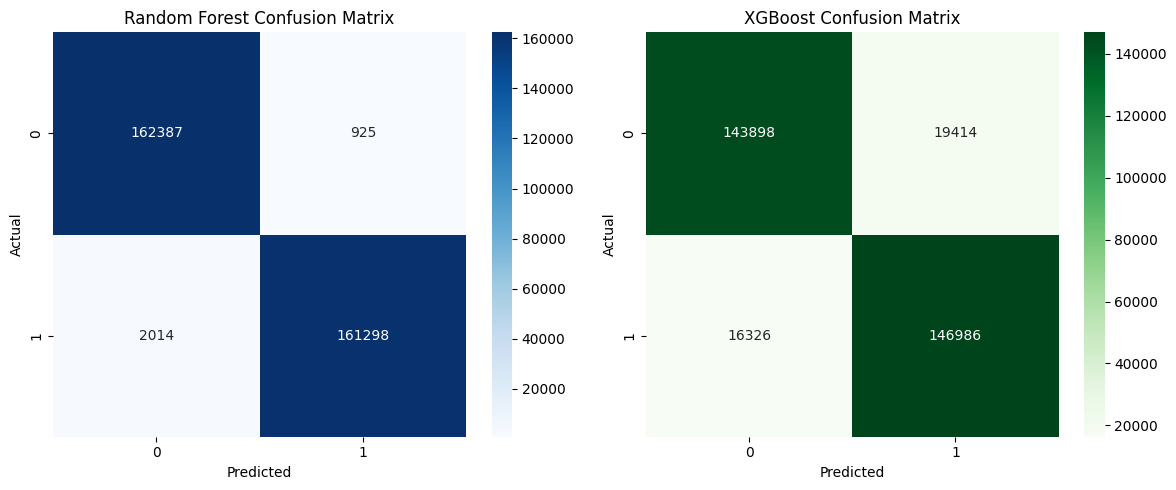

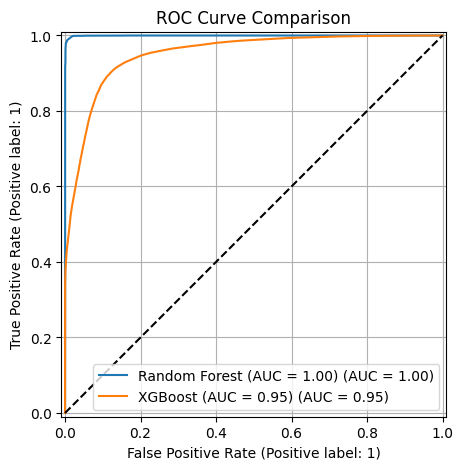

In [15]:
# Cell 4.1: Enhanced Evaluation for Combined Dataset (NSL-KDD + ToN-IoT)
# 1️⃣ Confusion Matrix Heatmaps (Side by Side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_combined, y_rf_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_combined, y_xgb_pred), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 2️⃣ ROC Curve Comparison
y_proba_rf = rf_combined.predict_proba(X_combined_pca)[:, 1]
y_proba_xgb = xgb_combined.predict_proba(X_combined_pca)[:, 1]

fig, ax = plt.subplots(figsize=(7, 5))

RocCurveDisplay.from_predictions(
    y_combined, y_proba_rf,
    name=f'Random Forest (AUC = {roc_auc_score(y_combined, y_proba_rf):.2f})',
    ax=ax
)

RocCurveDisplay.from_predictions(
    y_combined, y_proba_xgb,
    name=f'XGBoost (AUC = {roc_auc_score(y_combined, y_proba_xgb):.2f})',
    ax=ax
)

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.grid()
plt.show()


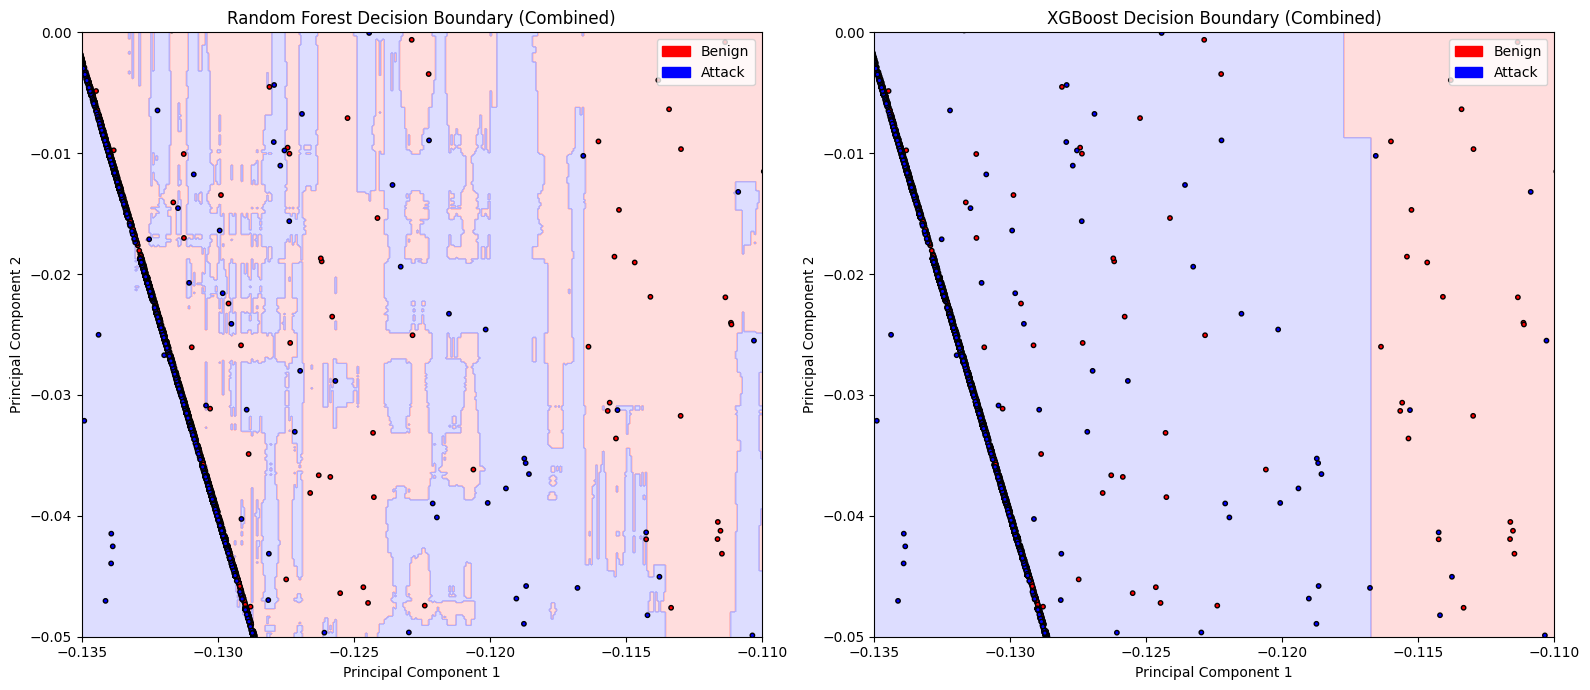

In [16]:
# Cell 4.2: Enhanced Decision Boundary Visualization for Combined Dataset

# Step 1: Function to plot decision boundaries with zoomed-in range
def plot_decision_boundary(model, X, y, ax, title):
    x_min, x_max = -0.135, -0.11
    y_min, y_max = -0.05, 0

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])  # red=class 0, blue=class 1 background
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])   # red=class 0, blue=class 1 points

    ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    # Add legend
    red_patch = mpatches.Patch(color='#FF0000', label='Benign')
    blue_patch = mpatches.Patch(color='#0000FF', label='Attack')
    ax.legend(handles=[red_patch, blue_patch], loc='upper right')

# Step 2: Plot both models side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
plot_decision_boundary(rf_combined, X_combined_pca, y_combined, axs[0], "Random Forest Decision Boundary (Combined)")
plot_decision_boundary(xgb_combined, X_combined_pca, y_combined, axs[1], "XGBoost Decision Boundary (Combined)")
plt.tight_layout()
plt.show()


🧹 Dropped 9 highly correlated features:
['srv_serror_rate', 'SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS', 'NUM_PKTS_1024_TO_1514_BYTES', 'ICMP_IPV4_TYPE']


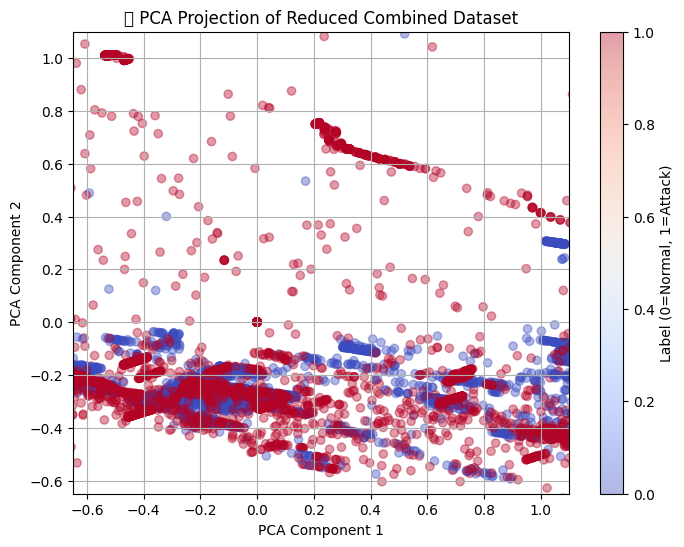

In [17]:
# Cell 4.3  — Function for Redundant Feature Removal and PCA Projection

def reduce_and_project_features(df, label_col='label', corr_threshold=0.95, n_components=2):
    """
    Removes highly correlated features and projects dataset into 2D using PCA.

    Args:
        df (pd.DataFrame): Combined numeric dataframe including label column.
        label_col (str): Name of the target column.
        corr_threshold (float): Correlation threshold for dropping redundant features.
        n_components (int): Number of PCA components to keep.

    Returns:
        pd.DataFrame: Reduced feature set with label
        np.ndarray: PCA-transformed data
    """
    # 1. Drop highly correlated features
    corr_matrix = df.drop(columns=[label_col]).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > corr_threshold)]
    reduced_df = df.drop(columns=drop_cols)

    print(f"🧹 Dropped {len(drop_cols)} highly correlated features:")
    print(drop_cols)

    # 2. Handle NaNs and standardize
    features = reduced_df.drop(columns=[label_col]).fillna(reduced_df.mean(numeric_only=True))
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    # 3. Get label values (no need to reindex if we didn't drop rows)
    labels = reduced_df[label_col].values

    # 4. Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # 5. Plot PCA result
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='coolwarm', alpha=0.4)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("🧬 PCA Projection of Reduced Combined Dataset")
    plt.colorbar(label='Label (0=Normal, 1=Attack)')
    plt.grid(True)
    plt.xlim(-0.65, 1.1)
    plt.ylim(-0.65, 1.1)
    plt.show()

    # Reattach labels to reduced DataFrame
    reduced_df_clean = features.copy()
    reduced_df_clean[label_col] = labels

    return reduced_df_clean, X_pca

# 1. Combine the datasets with a source label
X_nsl_combined = X_nsl_res.copy()
X_nsl_combined['label'] = y_nsl_res
X_nsl_combined['source'] = 'NSL-KDD'

X_ton_combined = X_ton_res.copy()
X_ton_combined['label'] = y_ton_res
X_ton_combined['source'] = 'TON_IoT'

# 2. Merge both datasets
combined_df = pd.concat([X_nsl_combined, X_ton_combined], ignore_index=True)

# 3. Drop 'source' for correlation, keep only numeric
numeric_combined_df = combined_df.select_dtypes(include=[np.number])

# ✅ Run it
reduced_features_df, X_pca = reduce_and_project_features(numeric_combined_df, label_col='label')


In [18]:
# Cell 4.4: Explanation after combination

# Define column labels for clarity (features)
column_labels = [
    "src_bytes", "dst_bytes", "duration", "protocol", "service", 
    "flag", "land", "wrong_fragment", "urgent", "count"
]

print("🔍 Descriptive Statistics (Features):")
df_combined = pd.DataFrame(X_combined, columns=column_labels)
display(df_combined.describe())


🔍 Descriptive Statistics (Features):


,src_bytes,dst_bytes,duration,protocol,service,flag,land,wrong_fragment,urgent,count
count,326624.000000,3.266240e+05,3.266240e+05,326624.000000,3.266240e+05,326624.000000,3.266240e+05,326624.000000,326624.000000,326624.000000
mean,25670.674926,2.342308e+04,8.765735e+03,7.541250,3.719421e+02,39.526407,4.195442e+02,2.771910,7.228124,4.969559
std,24450.913223,3.645792e+06,2.574762e+06,24.817802,4.034985e+04,127.848275,3.578234e+04,644.456579,10.337712,8.975022
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,5.300000e+01,6.000000e+00,0.000000,0.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000
50%,33812.000000,2.390000e+02,6.000000e+00,0.000000,4.400000e+01,2.000000,1.200000e+01,0.000000,2.000000,2.000000
75%,48719.250000,2.800000e+03,1.700000e+01,0.000000,6.000000e+01,11.000000,6.700000e+01,1.000000,19.000000,2.000000
max,65534.000000,1.379964e+09,1.309937e+09,248.000000,2.117210e+07,20000.000000,1.875429e+07,367218.000000,223.000000,223.000000


📌 NSL-KDD: Features Most Positively Correlated with DDoS-like Attacks:
label              1.000000
serror_rate        0.640292
srv_serror_rate    0.637708
count              0.568162
rerror_rate        0.248124
wrong_fragment     0.092696
duration           0.048392
src_bytes          0.005243
dst_bytes          0.004219
srv_count          0.000410
Name: label, dtype: float64

📌 NSL-KDD: Features Most Negatively Correlated with DDoS-like Attacks:
serror_rate        0.640292
srv_serror_rate    0.637708
count              0.568162
rerror_rate        0.248124
wrong_fragment     0.092696
duration           0.048392
src_bytes          0.005243
dst_bytes          0.004219
srv_count          0.000410
urgent            -0.003206
Name: label, dtype: float64


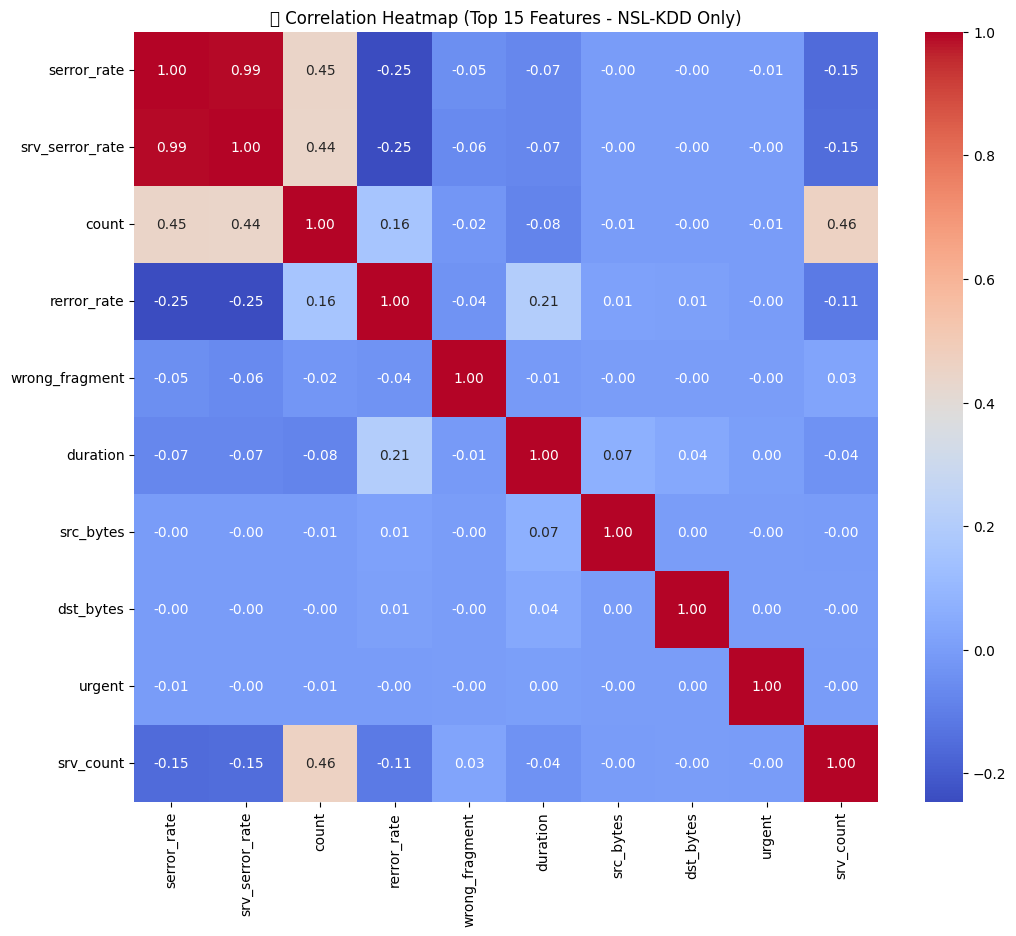

In [19]:
# Cell 5 NSL-KDD Correlation and Feature Insights

# 1. Combine features and labels for NSL-KDD
nsl_df_corr = X_nsl_res.copy()
nsl_df_corr['label'] = y_nsl_res

# 2. Select numeric data only
numeric_nsl_df = nsl_df_corr.select_dtypes(include=[np.number])

# 3. Compute correlation matrix
corr_matrix_nsl = numeric_nsl_df.corr()

# 4. Correlation with label
label_corr_nsl = corr_matrix_nsl['label'].sort_values(ascending=False)

# 5. Top positive correlations
print("📌 NSL-KDD: Features Most Positively Correlated with DDoS-like Attacks:")
print(label_corr_nsl.head(10))

# 6. Top negative correlations
print("\n📌 NSL-KDD: Features Most Negatively Correlated with DDoS-like Attacks:")
print(label_corr_nsl.tail(10))

# 7. Visualize top 15 absolute correlations (excluding label)
top_features_nsl = label_corr_nsl.drop('label').abs().sort_values(ascending=False).head(15).index

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_nsl_df[top_features_nsl].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("🔗 Correlation Heatmap (Top 15 Features - NSL-KDD Only)")
plt.show()


📌 TON_IoT: Features Most Positively Correlated with DDoS-like Attacks:
label                        1.000000
L4_DST_PORT                  0.110332
DNS_TTL_ANSWER               0.100065
NUM_PKTS_UP_TO_128_BYTES     0.027163
L4_SRC_PORT                  0.016817
NUM_PKTS_128_TO_256_BYTES    0.010462
RETRANSMITTED_IN_PKTS        0.003840
RETRANSMITTED_IN_BYTES       0.002561
OUT_PKTS                     0.001567
IN_BYTES                     0.001333
Name: label, dtype: float64

📌 TON_IoT: Features Most Negatively Correlated with DDoS-like Attacks:
FLOW_DURATION_MILLISECONDS   -0.218103
SERVER_TCP_FLAGS             -0.231242
MAX_IP_PKT_LEN               -0.289112
LONGEST_FLOW_PKT             -0.289112
MAX_TTL                      -0.305438
MIN_TTL                      -0.306409
MIN_IP_PKT_LEN               -0.337347
TCP_WIN_MAX_OUT              -0.352872
CLIENT_TCP_FLAGS             -0.368953
TCP_WIN_MAX_IN               -0.382053
Name: label, dtype: float64


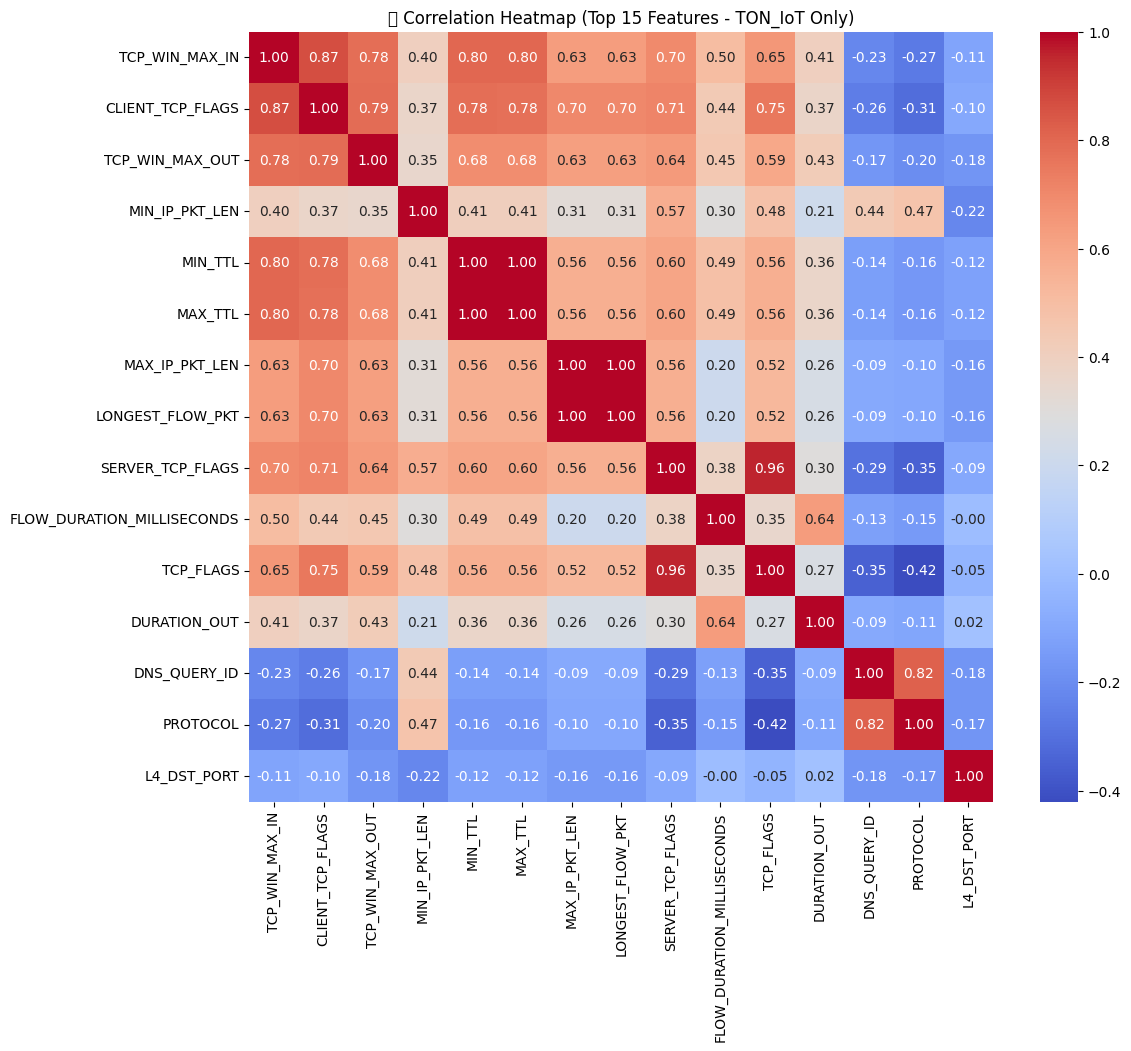

In [20]:
# Cell 5.1 — TON_IoT Correlation and Feature Insights

# 1. Combine features and labels for TON_IoT
ton_df_corr = X_ton_res.copy()
ton_df_corr['label'] = y_ton_res

# 2. Select only numeric columns (already numeric after preprocessing)
numeric_ton_df = ton_df_corr.select_dtypes(include=[np.number])

# 3. Compute correlation matrix
corr_matrix_ton = numeric_ton_df.corr()

# 4. Correlation with label
label_corr_ton = corr_matrix_ton['label'].sort_values(ascending=False)

# 5. Print top positively correlated features
print("📌 TON_IoT: Features Most Positively Correlated with DDoS-like Attacks:")
print(label_corr_ton.head(10))

# 6. Print top negatively correlated features
print("\n📌 TON_IoT: Features Most Negatively Correlated with DDoS-like Attacks:")
print(label_corr_ton.tail(10))

# 7. Heatmap of top 15 absolute correlations
top_features_ton = label_corr_ton.drop('label').abs().sort_values(ascending=False).head(15).index

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_ton_df[top_features_ton].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("🔗 Correlation Heatmap (Top 15 Features - TON_IoT Only)")
plt.show()


📌 Features Most Positively Correlated with DDoS-like Attacks:
label                       1.000000
serror_rate                 0.640292
srv_serror_rate             0.637708
count                       0.568162
rerror_rate                 0.248124
L4_DST_PORT                 0.110332
DNS_TTL_ANSWER              0.100065
wrong_fragment              0.092696
duration                    0.048392
NUM_PKTS_UP_TO_128_BYTES    0.027163
Name: label, dtype: float64

📌 Features Most Negatively Correlated with DDoS-like Attacks:
FLOW_DURATION_MILLISECONDS   -0.218103
SERVER_TCP_FLAGS             -0.231242
LONGEST_FLOW_PKT             -0.289112
MAX_IP_PKT_LEN               -0.289112
MAX_TTL                      -0.305438
MIN_TTL                      -0.306409
MIN_IP_PKT_LEN               -0.337347
TCP_WIN_MAX_OUT              -0.352872
CLIENT_TCP_FLAGS             -0.368953
TCP_WIN_MAX_IN               -0.382053
Name: label, dtype: float64


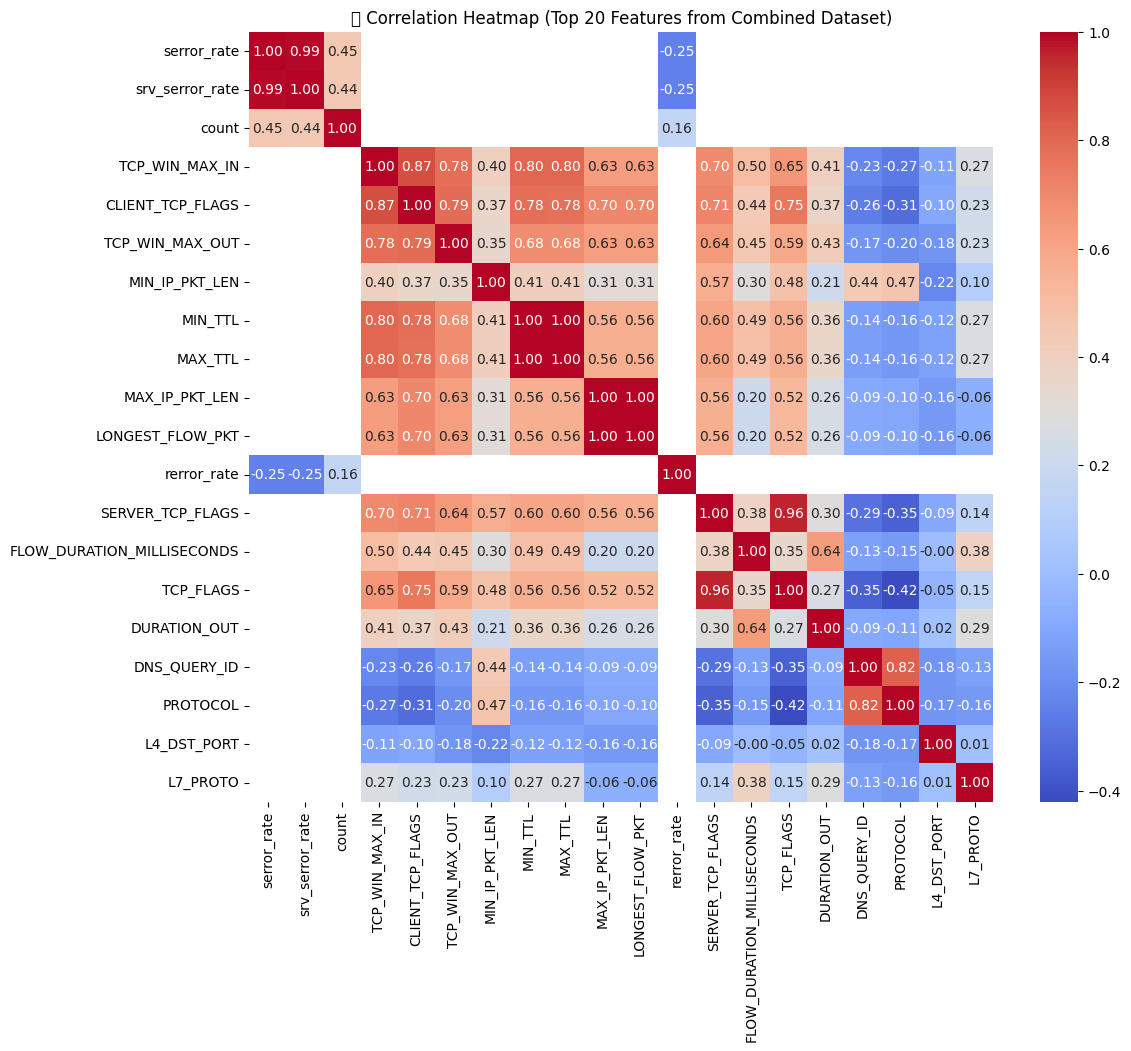

In [21]:
# Cell 5.2 — Correlation and Feature Insights on Combined Dataset (NSL-KDD + TON_IoT)

# 1. Compute correlation matrix
correlation_matrix = numeric_combined_df.corr()

# 2. Correlation with respect to the label
label_corr = correlation_matrix['label'].sort_values(ascending=False)

# 3. Print top positively correlated features
print("📌 Features Most Positively Correlated with DDoS-like Attacks:")
print(label_corr.head(10))

# 4. Print top negatively correlated features
print("\n📌 Features Most Negatively Correlated with DDoS-like Attacks:")
print(label_corr.tail(10))

# 5. Heatmap of top 15 correlated features
top_features = label_corr.drop('label').abs().sort_values(ascending=False).head(20).index

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_combined_df[top_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("🔗 Correlation Heatmap (Top 20 Features from Combined Dataset)")
plt.show()


📌 Top 20 Features and Their Dataset Origin:
serror_rate                    → NSL-KDD
srv_serror_rate                → NSL-KDD
count                          → NSL-KDD
TCP_WIN_MAX_IN                 → TON_IoT
CLIENT_TCP_FLAGS               → TON_IoT
TCP_WIN_MAX_OUT                → TON_IoT
MIN_IP_PKT_LEN                 → TON_IoT
MIN_TTL                        → TON_IoT
MAX_TTL                        → TON_IoT
MAX_IP_PKT_LEN                 → TON_IoT
LONGEST_FLOW_PKT               → TON_IoT
rerror_rate                    → NSL-KDD
SERVER_TCP_FLAGS               → TON_IoT
FLOW_DURATION_MILLISECONDS     → TON_IoT
TCP_FLAGS                      → TON_IoT
DURATION_OUT                   → TON_IoT
DNS_QUERY_ID                   → TON_IoT
PROTOCOL                       → TON_IoT
L4_DST_PORT                    → TON_IoT
L7_PROTO                       → TON_IoT


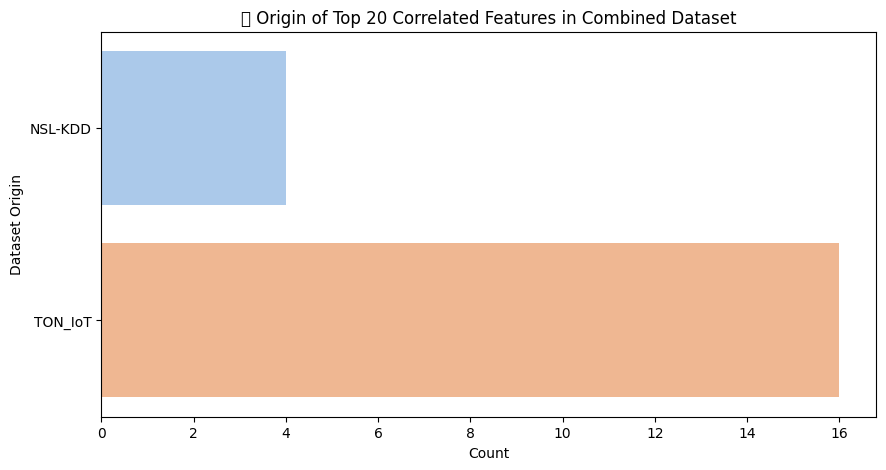

In [22]:
# Cell 5.3 — Identify Dataset Origin of Top Features from Combined Correlation Heatmap

# 🔹 Step 1: Ensure origin tagging exists
X_nsl_res['origin'] = 'NSL-KDD'
X_ton_res['origin'] = 'TON_IoT'

# 🔹 Step 2: Combine datasets again with origin column, only feature columns (not label)
combined_features_with_origin = pd.concat([X_nsl_res, X_ton_res], axis=0)

# 🔹 Step 3: Identify feature origin (excluding non-feature columns)
nsl_features = set(X_nsl_res.columns) - {'origin'}
ton_features = set(X_ton_res.columns) - {'origin'}

# 🔹 Step 4: Analyze top 15 features from Cell 5.2
# (Use 'top_features' variable from Cell 5.2, assumed still in scope)
feature_origin_map = {}
for feature in top_features:
    if feature in nsl_features and feature not in ton_features:
        feature_origin_map[feature] = "NSL-KDD"
    elif feature in ton_features and feature not in nsl_features:
        feature_origin_map[feature] = "TON_IoT"
    elif feature in nsl_features and feature in ton_features:
        feature_origin_map[feature] = "Both"
    else:
        feature_origin_map[feature] = "Unknown"

# 🔹 Step 5: Display the origin of each top feature
print("📌 Top 20 Features and Their Dataset Origin:")
for feat, origin in feature_origin_map.items():
    print(f"{feat:<30} → {origin}")

# 🔹 Step 6: Visualize as bar plot
plt.figure(figsize=(10, 5))
sns.countplot(y=list(feature_origin_map.values()), palette="pastel")
plt.title("🔍 Origin of Top 20 Correlated Features in Combined Dataset")
plt.xlabel("Count")
plt.ylabel("Dataset Origin")
plt.show()


In [23]:
# Cell 6 — DDoS Mitigation Simulation using Pretrained Models (on PCA-transformed combined dataset)

def mitigation_simulator(predictions, model_name, count=15):
    print(f"\n🛡️ {model_name} — DDoS Mitigation Simulation:")
    for i, label in enumerate(predictions[:count]):
        if label == 1:
            print(f"Packet {i+1}: ⚠️ DDoS Detected → Dropping packet & blacklisting source IP")
        else:
            print(f"Packet {i+1}: ✅ Normal traffic → Allowing packet")

# Run predictions using trained models on X_combined_pca
rf_preds = rf_combined.predict(X_combined_pca)
xgb_preds = xgb_combined.predict(X_combined_pca)

# Simulate DDoS mitigation based on predictions
mitigation_simulator(rf_preds, model_name="Random Forest")
mitigation_simulator(xgb_preds, model_name="XGBoost")



🛡️ Random Forest — DDoS Mitigation Simulation:
Packet 1: ✅ Normal traffic → Allowing packet
Packet 2: ✅ Normal traffic → Allowing packet
Packet 3: ⚠️ DDoS Detected → Dropping packet & blacklisting source IP
Packet 4: ✅ Normal traffic → Allowing packet
Packet 5: ✅ Normal traffic → Allowing packet
Packet 6: ⚠️ DDoS Detected → Dropping packet & blacklisting source IP
Packet 7: ⚠️ DDoS Detected → Dropping packet & blacklisting source IP
Packet 8: ⚠️ DDoS Detected → Dropping packet & blacklisting source IP
Packet 9: ⚠️ DDoS Detected → Dropping packet & blacklisting source IP
Packet 10: ⚠️ DDoS Detected → Dropping packet & blacklisting source IP
Packet 11: ⚠️ DDoS Detected → Dropping packet & blacklisting source IP
Packet 12: ⚠️ DDoS Detected → Dropping packet & blacklisting source IP
Packet 13: ✅ Normal traffic → Allowing packet
Packet 14: ⚠️ DDoS Detected → Dropping packet & blacklisting source IP
Packet 15: ⚠️ DDoS Detected → Dropping packet & blacklisting source IP

🛡️ XGBoost — DDoS Mi

In [24]:
# Cell 6.1: Simulated Firewall Rules Based on Detection Outcome

def advanced_mitigation(model, X_data, threshold=0.8):
    print("\n🛡️ Advanced DDoS Mitigation System (Threshold-Based)\n")

    predictions = model.predict(X_data)

    if hasattr(model, "predict_proba"):
        probability_scores = model.predict_proba(X_data)[:, 1]
    else:
        probability_scores = [1.0 if p == 1 else 0.0 for p in predictions]

    for i in range(min(len(predictions), 15)):
        prob = probability_scores[i]
        if predictions[i] == 1 and prob >= threshold:
            print(f"[Packet {i+1}] ⚠️ High Confidence DDoS ({prob:.2f}) → Block IP + Alert Admin")
        elif predictions[i] == 1:
            print(f"[Packet {i+1}] ⚠️ Possible DDoS ({prob:.2f}) → Monitor Traffic, Rate-Limit IP")
        else:
            print(f"[Packet {i+1}] ✅ Benign Traffic ({prob:.2f}) → Allow")

# 🔁 Run Simulation: Random Forest Model
print("\n🔍 Simulation for Random Forest Model:")
advanced_mitigation(rf_combined, X_combined_pca)

# 🔁 Run Simulation: XGBoost Model
print("\n🔍 Simulation for XGBoost Model:")
advanced_mitigation(xgb_combined, X_combined_pca)


🔍 Simulation for Random Forest Model:

🛡️ Advanced DDoS Mitigation System (Threshold-Based)

[Packet 1] ✅ Benign Traffic (0.00) → Allow
[Packet 2] ✅ Benign Traffic (0.02) → Allow
[Packet 3] ⚠️ High Confidence DDoS (1.00) → Block IP + Alert Admin
[Packet 4] ✅ Benign Traffic (0.00) → Allow
[Packet 5] ✅ Benign Traffic (0.00) → Allow
[Packet 6] ⚠️ High Confidence DDoS (1.00) → Block IP + Alert Admin
[Packet 7] ⚠️ High Confidence DDoS (1.00) → Block IP + Alert Admin
[Packet 8] ⚠️ High Confidence DDoS (1.00) → Block IP + Alert Admin
[Packet 9] ⚠️ High Confidence DDoS (1.00) → Block IP + Alert Admin
[Packet 10] ⚠️ High Confidence DDoS (1.00) → Block IP + Alert Admin
[Packet 11] ⚠️ High Confidence DDoS (1.00) → Block IP + Alert Admin
[Packet 12] ⚠️ High Confidence DDoS (1.00) → Block IP + Alert Admin
[Packet 13] ✅ Benign Traffic (0.00) → Allow
[Packet 14] ⚠️ High Confidence DDoS (0.98) → Block IP + Alert Admin
[Packet 15] ⚠️ High Confidence DDoS (1.00) → Block IP + Alert Admin

🔍 Simulation f

In [25]:
# Cell 7: Summary of Results for Both Models

# Generate predictions for both models
y_xgb_pred = xgb_combined.predict(X_combined_pca)
y_rf_pred = rf_combined.predict(X_combined_pca)

# Calculate metrics for XGBoost
xgb_tn, xgb_fp, xgb_fn, xgb_tp = confusion_matrix(y_combined, y_xgb_pred).ravel()
xgb_auc = roc_auc_score(y_combined, y_xgb_pred)

# Calculate metrics for Random Forest
rf_tn, rf_fp, rf_fn, rf_tp = confusion_matrix(y_combined, y_rf_pred).ravel()
rf_auc = roc_auc_score(y_combined, y_rf_pred)

# Create summary DataFrame
summary = pd.DataFrame({
    "Metric": [
        "True Positives", "False Positives", "True Negatives", "False Negatives",
        "Accuracy", "F1 Score", "AUC"
    ],
    "XGBoost": [
        xgb_tp, xgb_fp, xgb_tn, xgb_fn,
        round(accuracy_score(y_combined, y_xgb_pred), 4),
        round(f1_score(y_combined, y_xgb_pred), 4),
        round(xgb_auc, 4)
    ],
    "Random Forest": [
        rf_tp, rf_fp, rf_tn, rf_fn,
        round(accuracy_score(y_combined, y_rf_pred), 4),
        round(f1_score(y_combined, y_rf_pred), 4),
        round(rf_auc, 4)
    ]
})

print("\n📋 Detection Summary for Both Models:\n")
print(summary.to_string(index=False))


📋 Detection Summary for Both Models:

         Metric     XGBoost  Random Forest
 True Positives 146986.0000     161298.000
False Positives  19414.0000        925.000
 True Negatives 143898.0000     162387.000
False Negatives  16326.0000       2014.000
       Accuracy      0.8906          0.991
       F1 Score      0.8916          0.991
            AUC      0.8906          0.991


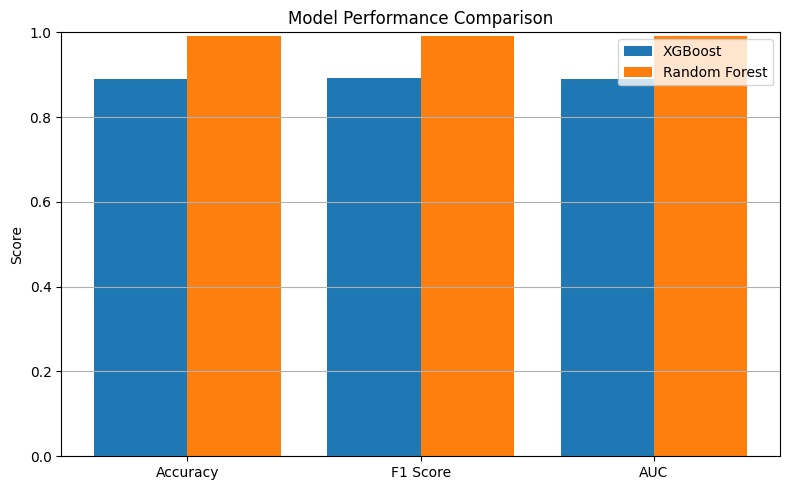

In [26]:
# Cell 8.1: Visual Comparison of Model Performance

metrics = ["Accuracy", "F1 Score", "AUC"]
xgb_scores = [
    round(accuracy_score(y_combined, y_xgb_pred), 4),
    round(f1_score(y_combined, y_xgb_pred), 4),
    round(xgb_auc, 4)
]
rf_scores = [
    round(accuracy_score(y_combined, y_rf_pred), 4),
    round(f1_score(y_combined, y_rf_pred), 4),
    round(rf_auc, 4)
]

x = range(len(metrics))
plt.figure(figsize=(8, 5))
plt.bar(x, xgb_scores, width=0.4, label='XGBoost', align='center')
plt.bar([i + 0.4 for i in x], rf_scores, width=0.4, label='Random Forest', align='center')
plt.xticks([i + 0.2 for i in x], metrics)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()